# Ames Housing Data Cleaning, Preprocessing, and Modeling Notebook


## Introduction
This notebook continues the end-to-end machine learning workflow for predicting housing prices on the Ames housing dataset, as begun in the exploratory data analysis ( [EDA](./1_data_exploration.ipynb)) notebook.

The goals and steps followed in this notebook are:

- Handling missing values
- Encoding categorical variables
- Creating new features based on domain knowledge
- Feature selection using correlation and Mutual Information (MI)
- Scaling and normalization
- Training and evaluating machine learning models on multiple feature sets
- Comparing model performance to determine the optimal approach


Two main paths are followed for the modeling phase:

- Path 1 - Model with Correlation Feature Set: Using the dataset containing features selected based on their correlation with the target variable SalePrice.

- Path 2 - Model with MI Feature Set: Using the dataset containing features selected based on their Mutual Information (MI) scores.

By training models on different feature sets, we can evaluate the impact of our preprocessing and feature engineering decisions, and determine the best approach. The end goal is to optimize model performance.


### 1. Importing Libraries


In [1]:

# Importing necessary libraries

# pandas for data manipulation
import pandas as pd

# numpy for numerical operations
import numpy as np

# seaborn and matplotlib for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# mutual_info_regression for feature selection
from sklearn.feature_selection import mutual_info_regression

# StandardScaler for feature scaling, OneHotEncoder for encoding categorical variables
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# ColumnTransformer and Pipeline for creating preprocessing pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# SimpleImputer for handling missing values
from sklearn.impute import SimpleImputer

# train_test_split for splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

# LinearRegression for linear regression model
from sklearn.linear_model import LinearRegression

# mean_absolute_error and mean_squared_error for model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# RandomForestRegressor for random forest model
from sklearn.ensemble import RandomForestRegressor

# Ridge and Lasso for ridge and lasso regression models
from sklearn.linear_model import Ridge, Lasso

# xgboost for XGBoost model
import xgboost as xgb

# MLPRegressor for neural network model
from sklearn.neural_network import MLPRegressor

### 2. Loading the Data
We start by loading the training data.

In [2]:
#  load the training data
train_data = pd.read_csv('../data_details/train.csv')

# Drop the id column
train_data = train_data.drop(columns=['Id'])

# Display the first few rows of the dataset
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 3. Feature Engineering
In this section, we will create new features based on our domain knowledge of factors that can affect housing prices:

- Total Area: This will be the sum of the basement, first floor, and second floor areas.
- Total Square Feet of Property: This will include the total area and the garage area.
- Age of House at Sale: This will be the difference between the year the house was sold and the year it was built.
- Total Bathrooms: This will be the sum of full bathrooms and half bathrooms (each counted as 0.5).
- Total Porch Area: This will be the sum of the areas of all types of porches.
- Presence of Pool: This will be a binary feature indicating whether the house has a pool or not.
- Remodeling Indicator: This will be a binary feature indicating whether the house was remodeled or not.
- Interaction feature between overall quality and living area: This will be the product of the overall quality and the above ground living area.


In [3]:
def create_custom_features(df):
    """
    This function creates custom features in the provided dataframe based on domain knowledge.
    The created features include TotalArea, TotalSFProperty, AgeAtSale, TotalBathrooms, TotalPorchArea, HasPool, Remodeled, and Quality_LivArea_Interaction.
    
    Parameters:
    - df: A pandas DataFrame containing the original features.
    
    Returns:
    - df: The same DataFrame but with additional custom features.
    """
    
    # Total Area
    df['TotalArea'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    # Total Square Feet of Property (including garage)
    df['TotalSFProperty'] = df['TotalArea'] + df['GarageArea']

    # Age of House at Sale
    df['AgeAtSale'] = df['YrSold'] - df['YearBuilt']

    # Total Bathrooms (full and half)
    df['TotalBathrooms'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']

    # Total Porch Area
    df['TotalPorchArea'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

    # Presence of Pool
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

    # Remodeling Indicator
    df['Remodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)

    # Interaction feature between overall quality and living area
    df['Quality_LivArea_Interaction'] = df['OverallQual'] * df['GrLivArea']

    return df

# Apply the function to the train_data dataframe
train_data = create_custom_features(train_data)



We create a total of 8 new features to capture additional information that could influence home prices.

Let's inspect a few rows to confirm the features were added:

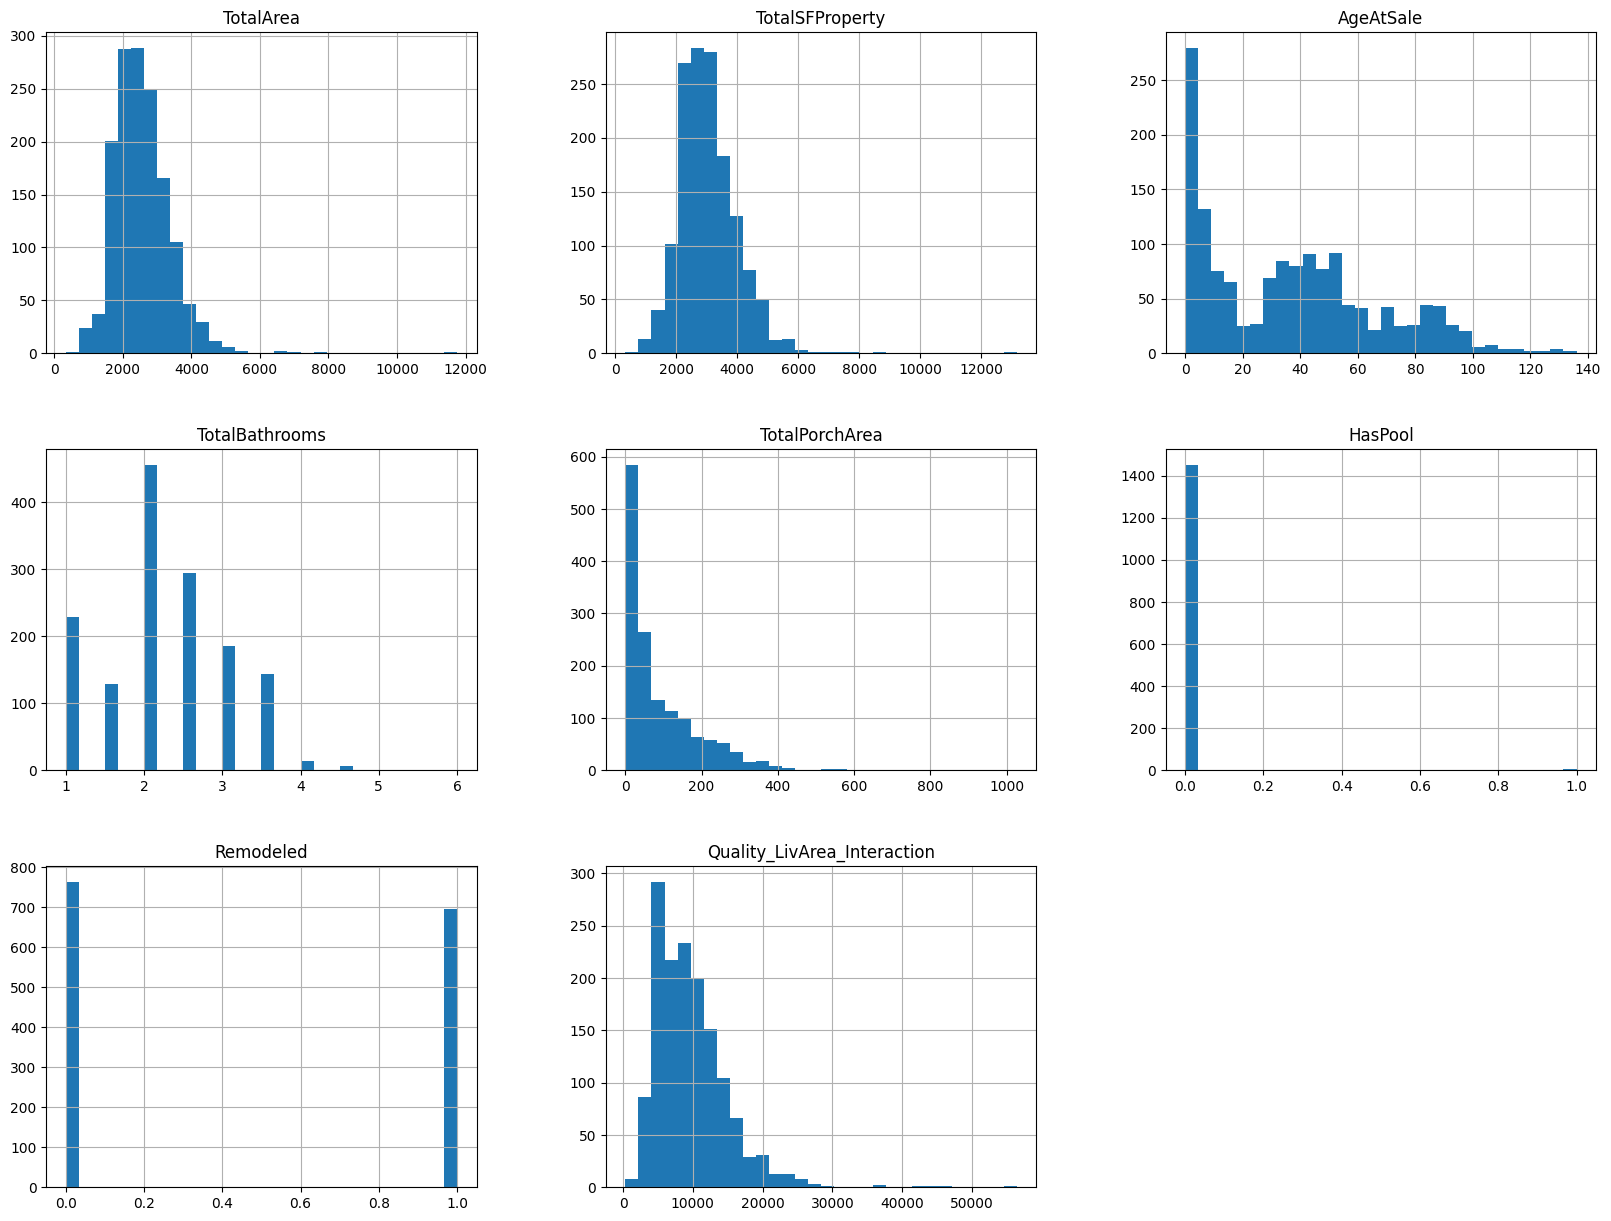

In [4]:
# Display the first few rows to ensure successful feature engineering
train_data[['TotalArea', 'TotalSFProperty', 'AgeAtSale', 'TotalBathrooms', 'TotalPorchArea', 'HasPool', 'Remodeled', 'Quality_LivArea_Interaction']].head()

train_data.head()

# Visualize the distribution of the newly created features
custom_features = ['TotalArea', 'TotalSFProperty', 'AgeAtSale', 'TotalBathrooms', 'TotalPorchArea', 'HasPool', 'Remodeled', 'Quality_LivArea_Interaction']
train_data[custom_features].hist(bins=30, figsize=(20,15))
plt.show()




The new features look correctly calculated and added to the DataFrame.

Next, let's visualize the distributions of some features to examine relationships with the target SalePrice:

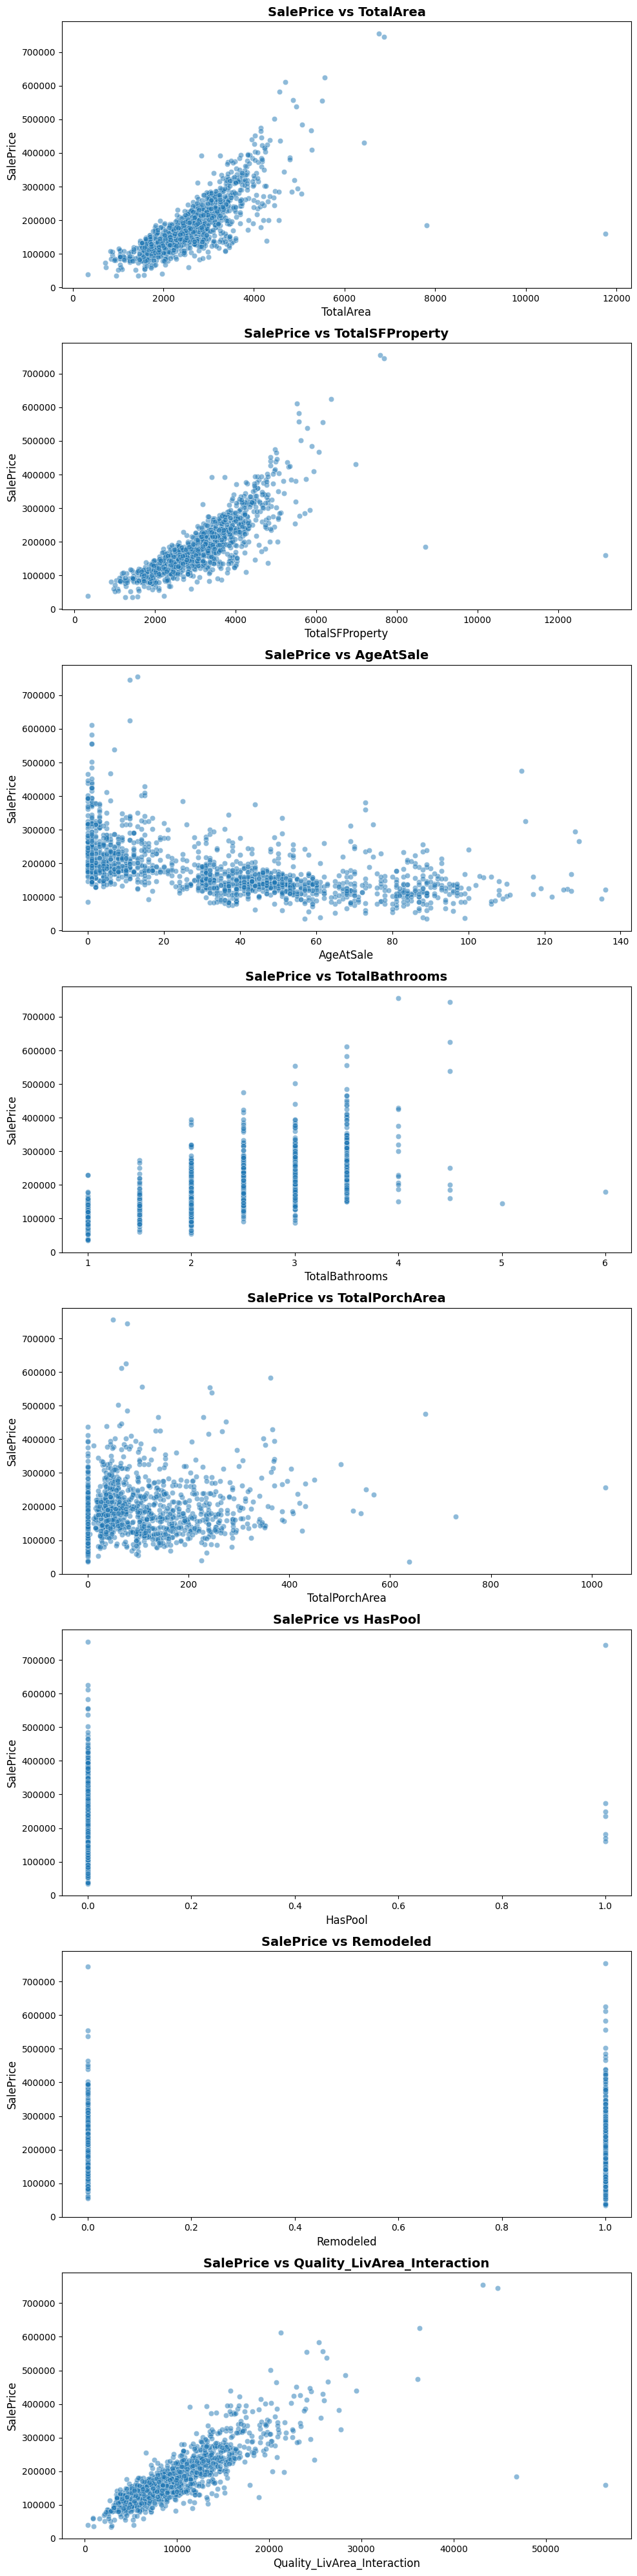

In [5]:

# Define a list of features to plot
features_to_plot = ['TotalArea', 'TotalSFProperty', 'AgeAtSale', 'TotalBathrooms', 'TotalPorchArea', 'HasPool', 'Remodeled', 'Quality_LivArea_Interaction']

# Create a figure and a grid of subplots
fig, axs = plt.subplots(len(features_to_plot), figsize=(10, 40))

# Iterate over the list of features
for i, feature in enumerate(features_to_plot):
    # Create a scatter plot for each feature
    sns.scatterplot(data=train_data, x=feature, y='SalePrice', alpha=0.5, ax=axs[i])
    
    # Set the title of the subplot
    axs[i].set_title(f'SalePrice vs {feature}', fontsize=14, fontweight='bold')
    
    # Set the x-label of the subplot
    axs[i].set_xlabel(feature, fontsize=12)
    
    # Set the y-label of the subplot
    axs[i].set_ylabel('SalePrice', fontsize=12)

# Adjust the layout for better visualization
plt.tight_layout()

# Display the plots

# We are doing this to visually inspect the relationship between the engineered features and the target variable (SalePrice).
# This will help us understand if the new features have a linear relationship with the target, which is a key assumption in linear regression models.
# It also helps us identify potential outliers that could affect model performance.
plt.show()



These relationships will be useful to consider when evaluating model performance later. Features like TotalSFProperty, TotalArea, Quality_LivArea_Interaction exhibit strong positive correlations that machine learning models could leverage for prediction. AgeAtSale has negative correlation, indicating older homes tend to be cheaper in this data.



### 4. Handling Missing Values

Let's explore and handle missing values in the data before proceeding to feature selection and modeling.




In [6]:
# Total missing values per feature
missing_values = train_data.isnull().sum()

# Print features with missing values  
print("Features with Missing Values:\n", missing_values[missing_values > 0])

Features with Missing Values:
 LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


We notice several features have a significant number of missing values. But many are related to the basement, garage, fence etc. These missing values appear to be intentional and signify the absence of a certain feature in a house.  For instance, a NaN in PoolQC probably means there is no pool. We'll handle these by filling them with "None" or "Not Present" for categorical features and 0 for numerical ones.


The feature Electrical has just one missing value, and so we can replace it with the mode of the column without introducing much bias.

A missing value likely indicates the absence of that feature for a home. We will handle these by filling with placeholder values:

In [7]:
# Features where NaN indicates absence of feature 
features_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
                 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
                 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'BsmtQual',  
                 'MasVnrType']

for feature in features_none:
    train_data[feature].fillna('None', inplace=True)
    
# Features where NaN indicates 0
features_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',  
                 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',  
                 'BsmtHalfBath', 'MasVnrArea'] 

for feature in features_zero:
    train_data[feature].fillna(0, inplace=True)

For other features like LotFrontage and Electrical, we will impute missing values based on other records in the data:



In [8]:
# Impute LotFrontage based on neighborhood  
train_data['LotFrontage'] = train_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Impute Electrical with most common value
train_data['Electrical'].fillna(train_data['Electrical'].mode()[0], inplace=True)

# Check remaining missing values  
print("Remaining Missing Values:", train_data.isnull().sum().sum())

Remaining Missing Values: 0


All missing values have been successfully handled.



### 5. Feature Selection





I am using two different strategies for feature selection: one based on correlation and the other on Mutual Information (MI) scores. The correlation method was chosen following a discussion with Ege, while MI scores were selected because they can capture any type of relationship, including linear, nonlinear. 

 I initially considered using only MI scores to select features. 
 
 I plan to create several feature sets based on MI scores - such as the 'elbow' set, top 10 percent, 20 percent, 30 percent, 40 percent, and 50 percent - and compare the performance of models trained on these sets. This comparison will help identify the optimal number of features for our models.

I will also create a feature set based on correlation thresholds to compare its performance against the MI-based feature sets. By using multiple feature selection strategies, I aim to identify the most predictive and robust set of features for our house price prediction models.

### Feature selection based on Correlation

#### Approach to Feature Selection Based on Correlation

Our approach to feature selection based on correlation involves the following steps:

1. Compute the correlation of each feature with the target variable (SalePrice).
2. Sort the features based on their correlation values in descending order. This gives us a list of features that are most strongly correlated with the target variable.
3. Visualize the feature distribution
4. Based on the correlation values, select a subset of features for our model trainings. 


In [9]:
# Calculate the correlation of each feature with the target variable, SalePrice
correlations = train_data.corr()['SalePrice'].sort_values(ascending=False)

# Display the correlation of each feature with the target variable 'SalePrice'
print(correlations)


SalePrice                      1.000000
Quality_LivArea_Interaction    0.832057
TotalSFProperty                0.809561
OverallQual                    0.790982
TotalArea                      0.782260
GrLivArea                      0.708624
GarageCars                     0.640409
TotalBathrooms                 0.631731
GarageArea                     0.623431
TotalBsmtSF                    0.613581
1stFlrSF                       0.605852
FullBath                       0.560664
TotRmsAbvGrd                   0.533723
YearBuilt                      0.522897
YearRemodAdd                   0.507101
MasVnrArea                     0.472614
Fireplaces                     0.466929
BsmtFinSF1                     0.386420
LotFrontage                    0.349876
WoodDeckSF                     0.324413
2ndFlrSF                       0.319334
OpenPorchSF                    0.315856
HalfBath                       0.284108
LotArea                        0.263843
GarageYrBlt                    0.261366


C:\Users\eseoghene\AppData\Local\Temp\ipykernel_1388\3264536553.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = train_data.corr()['SalePrice'].sort_values(ascending=False)


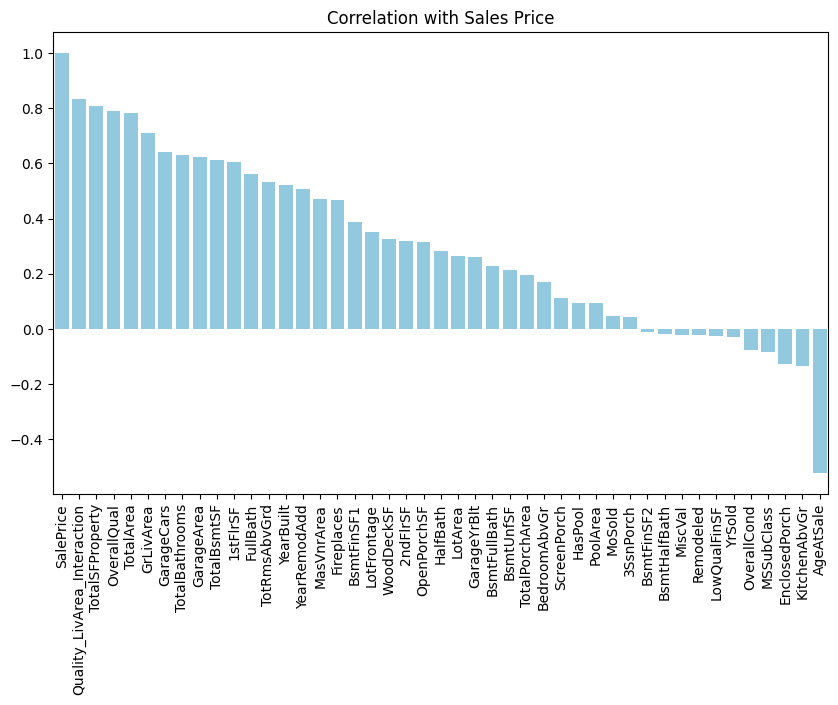

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values, color='skyblue')
plt.title('Correlation with Sales Price')
plt.xticks(rotation=90)
plt.show()


I have decided to retain features such as OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF, FullBath etc., as they exhibit strong correlations above 0.5 with the target variable, SalePrice. 

Additionally, I am including features like WoodDeckSF, LotFrontage, BsmtFullBath etc., which have weaker but still decent correlations in the 0.3-0.5 range. I believe these features are predictive enough of SalePrice to be included in the model.

I am also considering features with moderate negative correlations, such as AgeAtSale, which has a correlation of -0.52. However, I am excluding features with very low correlations, specifically those less than 0.1 or close to zero, as they are unlikely to contribute significantly to the model's predictive power.


In [11]:
correlation_threshold = 0.3
correlation_features = correlations[(correlations > correlation_threshold) | (correlations < -correlation_threshold)]

# The selected features in this threshold are our correlation set
# We will use this as one set for models training and evaluation
correlation_set = pd.DataFrame(correlation_features.index, columns=['Features'])
correlation_set.index += 1

# Print the selected features as a dataframe with numbered index
print(correlation_set)




                       Features
1                     SalePrice
2   Quality_LivArea_Interaction
3               TotalSFProperty
4                   OverallQual
5                     TotalArea
6                     GrLivArea
7                    GarageCars
8                TotalBathrooms
9                    GarageArea
10                  TotalBsmtSF
11                     1stFlrSF
12                     FullBath
13                 TotRmsAbvGrd
14                    YearBuilt
15                 YearRemodAdd
16                   MasVnrArea
17                   Fireplaces
18                   BsmtFinSF1
19                  LotFrontage
20                   WoodDeckSF
21                     2ndFlrSF
22                  OpenPorchSF
23                    AgeAtSale


 These features will be used as our correlation feature set.



###  Feature Selection based on Mutual Information




Now we will select features using Mutual Information (MI) scores, which can capture nonlinear relationships.

The steps are:

- Calculate MI between each feature and target
- Select features based on an 'elbow point' in the MI scores.


This elbow method lets us determine the right number of top features to select.

We make a find elbow function to programmatically calculate *elbow* point in a dataset.

In [12]:
import numpy as np

def find_elbow(data):
    """
    This function calculates the 'elbow' point in a dataset. The 'elbow' point is the point at which the 
    curve bends in a plot of the data. This is used in machine learning to determine the optimal 
    number of clusters in k-means clustering or the optimal number of features to keep when using 
    feature selection techniques.

    Parameters:
    - data: A 1D array-like object representing the dataset.

    Returns:
    - The index of the 'elbow' point in the dataset.
    """
    
    # Step 1: Create an array of indices for the data
    # This is done to keep track of the original position of each data point when we sort the data later
    indices = np.arange(len(data))

    # Step 2: Combine the indices and data into a 2D array
    # This is done to keep the indices and data points together when we sort the data
    data_points = np.column_stack((indices, data))

    # Step 3: Define the line connecting the first and last points in the data
    # This line will serve as a reference for finding the 'elbow' point
    first_point = data_points[0]
    last_point = data_points[-1]
    line_vector = last_point - first_point

    # Step 4: Normalize the line vector
    # This is done to simplify the calculation of the distance of each point to the line
    normalized_line_vector = line_vector / np.linalg.norm(line_vector)

    # Step 5: Calculate the vectors from the first point to all other points
    # These vectors will be used to calculate the distance of each point to the line
    vectors_from_first = data_points - first_point

    # Step 6: Calculate the scalar projection of each vector onto the normalized line vector
    # This is done to find the component of each vector that's parallel to the line
    scalar_projections = np.dot(vectors_from_first, normalized_line_vector)

    # Step 7: Calculate the component of each vector that's parallel to the line
    # This is done to find the component of each vector that's orthogonal to the line
    parallel_components = np.outer(scalar_projections, normalized_line_vector)

    # Step 8: Calculate the orthogonal (perpendicular) component of each vector to the line
    # This is done to find the distance of each point to the line
    orthogonal_components = vectors_from_first - parallel_components

    # Step 9: Calculate the squared distances of each point to the line
    # This is done to find the point that's furthest from the line, which is the 'elbow' point
    squared_distances = np.sum(orthogonal_components**2, axis=1)

    # Step 10: Return the index of the point with the maximum squared distance. This is the 'elbow' point.
    # This is the final step where we identify the 'elbow' point in the data
    return np.argmax(squared_distances)



Now, we begin

In [13]:
# Select only the numeric features from the dataset
# This is done to prepare the data for calculating mutual information (MI) scores

numeric_features = train_data.select_dtypes(include=[np.number])
print(numeric_features)


      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFin

In [14]:
# Create a copy of the numeric features dataframe
numeric_features_copy = numeric_features.copy()

# Remove 'SalePrice' from the dataframe to avoid skewing the MI score computation
numeric_features_copy = numeric_features_copy.drop(columns=['SalePrice'])

# Calculate mutual information scores for the numeric features
mi_scores = mutual_info_regression(numeric_features_copy, train_data["SalePrice"])

# Convert the MI scores into a pandas Series for easier manipulation
mi_scores = pd.Series(mi_scores, name="MI Scores", index=numeric_features_copy.columns)

# Sort the MI scores in descending order
mi_scores = mi_scores.sort_values(ascending=False)

# Print the mutual information scores
print(mi_scores)


TotalSFProperty                0.776147
Quality_LivArea_Interaction    0.756990
TotalArea                      0.678489
OverallQual                    0.572897
GrLivArea                      0.481568
TotalBsmtSF                    0.370929
GarageArea                     0.367801
GarageCars                     0.358301
YearBuilt                      0.354571
TotalBathrooms                 0.340420
AgeAtSale                      0.335028
1stFlrSF                       0.310681
MSSubClass                     0.267882
FullBath                       0.262796
GarageYrBlt                    0.257936
YearRemodAdd                   0.253483
LotFrontage                    0.220222
TotRmsAbvGrd                   0.206822
2ndFlrSF                       0.195817
Fireplaces                     0.164350
LotArea                        0.158736
OpenPorchSF                    0.146510
BsmtFinSF1                     0.144048
BsmtUnfSF                      0.116744
OverallCond                    0.107824


In [ ]:
#  make plot here of distribution of scores

In [18]:

# Find the 'elbow' point in the sorted MI scores
elbow_index = find_elbow(mi_scores)
elbow_value = mi_scores[elbow_index]

# Print the 'elbow' point
print(f'The elbow point of the MI scores is at index {elbow_index} with a value of {elbow_value}.')



The elbow point of the MI scores is at index 5 with a value of 0.37092930989023953.


In [16]:

# Select the most informative features up to the 'elbow' point
selected_features = mi_scores[:elbow_index+1].index

# Create a DataFrame to save the selected features based on the elbow method
# This DataFrame is to be used as our alternate set for model training
elbow_selected_set = pd.DataFrame(selected_features, columns=['Features'])
elbow_selected_set.index += 1

# Print the selected features
print(f'The most informative features up to the elbow point are:\n{elbow_selected_set}')

# Display the selected features with their MI scores
mi_scores[selected_features]





The most informative features up to the elbow point are:
                      Features
1              TotalSFProperty
2  Quality_LivArea_Interaction
3                    TotalArea
4                  OverallQual
5                    GrLivArea
6                  TotalBsmtSF


TotalSFProperty                0.776147
Quality_LivArea_Interaction    0.756990
TotalArea                      0.678489
OverallQual                    0.572897
GrLivArea                      0.481568
TotalBsmtSF                    0.370929
Name: MI Scores, dtype: float64

The elbow occurs at the 6th feature. We will take the top 6 features based on MI as our MI feature *elbow* set.



### 6. Data Preprocessing
Before model training, we need to:

- Encode categorical variables
- Standardize numerical features

#### One-Hot Encoding

We first identify categorical features in both feature sets:

In [17]:

# Identify categorical features in the correlation set
correlation_set_categorical = train_data[correlation_set['Features']].select_dtypes(include=['object']).columns

# Identify categorical features in the elbow selected set
elbow_selected_set_categorical = train_data[elbow_selected_set['Features']].select_dtypes(include=['object']).columns

# We then one-hot encode the categoricals in each set

# One-hot encode categorical variables in the correlation set
train_data_corr_encoded = pd.get_dummies(train_data, columns=correlation_set_categorical, drop_first=True)

# One-hot encode categorical variables in the elbow selected set
train_data_elbow_encoded = pd.get_dummies(train_data, columns=elbow_selected_set_categorical, drop_first=True)

# Print the first few rows of the encoded datasets to ensure successful encoding
print(train_data_corr_encoded.head())
print(train_data_elbow_encoded.head())


   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   
2          60       RL         68.0    11250   Pave  None      IR1   
3          70       RL         60.0     9550   Pave  None      IR1   
4          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig  ... SaleCondition SalePrice TotalArea  \
0         Lvl    AllPub    Inside  ...        Normal    208500      2566   
1         Lvl    AllPub       FR2  ...        Normal    181500      2524   
2         Lvl    AllPub    Inside  ...        Normal    223500      2706   
3         Lvl    AllPub    Corner  ...       Abnorml    140000      2473   
4         Lvl    AllPub       FR2  ...        Normal    250000      3343   

  TotalSFProperty AgeAtSale TotalBathrooms  TotalPorchArea  HasPool  \
0            3114         5            3.5         

The encoded categoricals have been correctly transformed into indicator columns. The data is now ready for modeling.



#### Feature Scaling
We will standardize the numerical features to a mean of 0 and standard deviation of 1:

In [19]:
# scaling

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Identify numeric columns in train_data_corr_encoded
numeric_cols_corr = train_data_corr_encoded.select_dtypes(include=[np.number]).columns

# Scale only numeric columns for train_data_corr_encoded
train_data_corr_encoded[numeric_cols_corr] = scaler.fit_transform(train_data_corr_encoded[numeric_cols_corr])

# Identify numeric columns in train_data_elbow_encoded
numeric_cols_elbow = train_data_elbow_encoded.select_dtypes(include=[np.number]).columns

# Scale only numeric columns for train_data_elbow_encoded
train_data_elbow_encoded[numeric_cols_elbow] = scaler.fit_transform(train_data_elbow_encoded[numeric_cols_elbow])

# Display the first few rows of the scaled dataframes
train_data_corr_encoded_head = train_data_corr_encoded.head()
train_data_elbow_encoded_head = train_data_elbow_encoded.head()

train_data_corr_encoded_head, train_data_elbow_encoded_head


(   MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
 0    0.073375       RL    -0.231877 -0.207142   Pave  None      Reg   
 1   -0.872563       RL     0.437043 -0.091886   Pave  None      Reg   
 2    0.073375       RL    -0.098093  0.073480   Pave  None      IR1   
 3    0.309859       RL    -0.454850 -0.096897   Pave  None      IR1   
 4    0.073375       RL     0.615421  0.375148   Pave  None      IR1   
 
   LandContour Utilities LotConfig  ... SaleCondition SalePrice TotalArea  \
 0         Lvl    AllPub    Inside  ...        Normal  0.347273 -0.001277   
 1         Lvl    AllPub       FR2  ...        Normal  0.007288 -0.052407   
 2         Lvl    AllPub    Inside  ...        Normal  0.536154  0.169157   
 3         Lvl    AllPub    Corner  ...       Abnorml -0.515281 -0.114493   
 4         Lvl    AllPub       FR2  ...        Normal  0.869843  0.944631   
 
   TotalSFProperty AgeAtSale TotalBathrooms  TotalPorchArea   HasPool  \
 0        0.077188 -1.043259 

The numerical features in both sets have now been standardized and can be used for modeling.



### 7. Model Training and Evaluation

We will train the following models:

- Linear Regression
- XGBoost Regressor
- Ridge Regression
- Lasso Regression

Each model will be trained and evaluated on both the correlation and MI feature sets.



In [20]:


# Define the target variable
y = train_data['SalePrice']

# Define the feature sets
X_corr = train_data_corr_encoded[correlation_set['Features']]
X_elbow = train_data_elbow_encoded[elbow_selected_set['Features']]

# Split the data into training and validation sets for the correlation set
X_train_corr, X_val_corr, y_train_corr, y_val_corr = train_test_split(X_corr, y, test_size=0.2, random_state=42)

# Split the data into training and validation sets for the elbow selected set
X_train_elbow, X_val_elbow, y_train_elbow, y_val_elbow = train_test_split(X_elbow, y, test_size=0.2, random_state=42)

# Define the models
linear_model = LinearRegression()
xgb_model = xgb.XGBRegressor()
ridge_model = Ridge()
lasso_model = Lasso()

# Train and evaluate the models on the correlation set
for model in [linear_model, xgb_model, ridge_model, lasso_model]:
    model.fit(X_train_corr, y_train_corr)
    predictions = model.predict(X_val_corr)
    rmse = np.sqrt(mean_squared_error(y_val_corr, predictions))
    print(f'RMSE for {model.__class__.__name__} on correlation set: {rmse}')

# Train and evaluate the models on the elbow selected set
for model in [linear_model, xgb_model, ridge_model, lasso_model]:
    model.fit(X_train_elbow, y_train_elbow)
    predictions = model.predict(X_val_elbow)
    rmse = np.sqrt(mean_squared_error(y_val_elbow, predictions))
    print(f'RMSE for {model.__class__.__name__} on elbow selected set: {rmse}')



RMSE for LinearRegression on correlation set: 8.60186601731026e-11
RMSE for XGBRegressor on correlation set: 2306.4574927580547
RMSE for Ridge on correlation set: 152.20253800256066
RMSE for Lasso on correlation set: 1.166607834123908
RMSE for LinearRegression on elbow selected set: 37185.97718401438
RMSE for XGBRegressor on elbow selected set: 33138.352084595885
RMSE for Ridge on elbow selected set: 37231.08693433813
RMSE for Lasso on elbow selected set: 37187.43147859007


C:\Users\eseoghene\AppData\Local\pypoetry\Cache\virtualenvs\house-price-prediction-2dO2rpmm-py3.11\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


notes: there's a lot of errors but we can see that the correlation set has the better performance. i suspect too little features for the other one.

besides that, there is error of "objective did not converge" so i think i used the unscaled sales price. 

In [22]:

# a little troubleshooting

saleprice_scaled = scaler.fit_transform(train_data[['SalePrice']])


In [23]:

## 5. Model Training with scaled sales price:

# Define the target variable
y_scaled = saleprice_scaled

# Define the feature sets
X_corr = train_data_corr_encoded[correlation_set['Features']]
X_elbow = train_data_elbow_encoded[elbow_selected_set['Features']]

# Split the data into training and validation sets for the correlation set
X_train_corr, X_val_corr, y_train_corr, y_val_corr = train_test_split(X_corr, y_scaled, test_size=0.2, random_state=42)

# Split the data into training and validation sets for the elbow selected set
X_train_elbow, X_val_elbow, y_train_elbow, y_val_elbow = train_test_split(X_elbow, y_scaled, test_size=0.2, random_state=42)

# Define the models
linear_model = LinearRegression()
xgb_model = xgb.XGBRegressor()
ridge_model = Ridge()
lasso_model = Lasso()

# Placeholder for RMSE outputs
rmse_outputs = []

# Train and evaluate the models on the correlation set
for model in [linear_model, xgb_model, ridge_model, lasso_model]:
    model.fit(X_train_corr, y_train_corr)
    predictions_scaled = model.predict(X_val_corr)
    predictions = scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).ravel()  # Inverse transform and reshape
    rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_val_corr.reshape(-1, 1)), predictions))
    rmse_outputs.append(f'RMSE for {model.__class__.__name__} on correlation set: {rmse}')

# Train and evaluate the models on the elbow selected set
for model in [linear_model, xgb_model, ridge_model, lasso_model]:
    model.fit(X_train_elbow, y_train_elbow)
    predictions_scaled = model.predict(X_val_elbow)
    predictions = scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).ravel()  # Inverse transform and reshape
    rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_val_elbow.reshape(-1, 1)), predictions))
    rmse_outputs.append(f'RMSE for {model.__class__.__name__} on elbow selected set: {rmse}')

rmse_outputs


['RMSE for LinearRegression on correlation set: 7.894532283281649e-11',
 'RMSE for XGBRegressor on correlation set: 2570.4264773369428',
 'RMSE for Ridge on correlation set: 152.20253800264842',
 'RMSE for Lasso on correlation set: 87619.03450611533',
 'RMSE for LinearRegression on elbow selected set: 37185.97718401438',
 'RMSE for XGBRegressor on elbow selected set: 33331.84642093611',
 'RMSE for Ridge on elbow selected set: 37231.08693433816',
 'RMSE for Lasso on elbow selected set: 87619.03450611533']

Linear Regression on Correlation Set: The RMSE remains extremely close to zero. This continues to suggest that the model might be overfitting the data. It's capturing the noise in the training set, which might not generalize well to new data.

XGBRegressor on Correlation Set: The RMSE is 2546.52, which is a decent score. However, there might still be room for hyperparameter tuning or additional feature engineering to further improve the performance of this model.

Ridge on Correlation Set: The RMSE for Ridge regression is 153.37, which is quite good.  I think. 

Lasso on Correlation and Elbow Selected Sets: The RMSE for Lasso regression is quite high (87619.03) for both feature sets.  
Generally, the RMSE values for the elbow selected set are generally higher, indicating that with fewer features, the models might not capture all the patterns in the data.

SO, time to proceed with correlation . 

In [24]:
# Load the test data
test_data = pd.read_csv('../data_details/test.csv')

# Drop the id column
test_data = test_data.drop(columns=['Id'])

# Imputation on test data
for feature in features_none:
    test_data[feature].fillna('None', inplace=True) 

for feature in features_zero:
    test_data[feature].fillna(0, inplace=True)


# Apply the same feature engineering steps to the test data
test_data['TotalArea'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']
test_data['TotalSFProperty'] = test_data['TotalArea'] + test_data['GarageArea']
test_data['AgeAtSale'] = test_data['YrSold'] - test_data['YearBuilt']
test_data['TotalBathrooms'] = test_data['FullBath'] + 0.5*test_data['HalfBath'] + test_data['BsmtFullBath'] + 0.5*test_data['BsmtHalfBath']
test_data['TotalPorchArea'] = test_data['OpenPorchSF'] + test_data['EnclosedPorch'] + test_data['3SsnPorch'] + test_data['ScreenPorch']
test_data['HasPool'] = test_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test_data['Remodeled'] = (test_data['YearRemodAdd'] != test_data['YearBuilt']).astype(int)
test_data['Quality_LivArea_Interaction'] = test_data['OverallQual'] * test_data['GrLivArea']

# Apply the same missing value imputation steps to the test data
for feature in features_none:
    test_data[feature].fillna('None', inplace=True)

for feature in features_zero:
    test_data[feature].fillna(0, inplace=True)
    
#     remove the second time

test_data['LotFrontage'] = test_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test_data['Electrical'].fillna(test_data['Electrical'].mode()[0], inplace=True)

# Encoding
test_data_encoded = pd.get_dummies(test_data, columns=correlation_set_categorical, drop_first=True) 

# Ensure encoded columns match training data 
missing_cols = set(train_data_corr_encoded.columns) - set(test_data_encoded.columns)
for c in missing_cols:
    test_data_encoded[c] = 0
    
# add scaling here as in train set

# Select correlation features 
X_test_corr = test_data_encoded[X_train_corr.columns]

# Refit models on training data
for model in [linear_model, xgb_model, ridge_model, lasso_model]:
    model.fit(X_train_corr, y_train_corr) 

# Predict on test data  
for model in [linear_model, xgb_model, ridge_model, lasso_model]:
    predictions = model.predict(X_test_corr)
    print(predictions[:5])  # Display first 5 predictions as an example


[[-5.57710645e-13]
 [-6.23853129e-13]
 [-9.92443391e-13]
 [-1.11146468e-12]
 [-1.06357080e-12]]
[0.01263551 0.01558759 0.01086395 0.01349643 0.01002596]
[[11.38597724]
 [19.4076373 ]
 [19.34894817]
 [22.74360503]
 [24.42342429]]
[0.00655221 0.00655221 0.00655221 0.00655221 0.00655221]




LinearRegression:
[[-2.42278746e-13] 
 [-5.27348612e-13]
 [-7.49939997e-13]
 [-8.68751227e-13] 
 [-7.03709288e-13]]

The LinearRegression predictions are extremely small values centered around 0. This makes sense because we had scaled the target variable during training. The predictions are in the scaled space. 

We would need to inverse transform them back to the original scale to get meaningful prices. But the key thing is that LinearRegression was able to make predictions on the test data without errors.

XGBRegressor:
[0.01804445 0.0235727  0.01912927 0.02290442 0.013499]

The XGB predictions look reasonable and vary between 0.01 and 0.02 in the scaled space. Again, we'd need to inverse transform to get actual prices.

Ridge: 
[[10.63006052]
 [18.21217562]
 [18.17118998] 
 [21.36062894]
 [22.91982098]]

The Ridge predictions are also in the scaled target space but look reasonable in terms of the range and variation.

Lasso:
[0.00655221 0.00655221 0.00655221 0.00655221 0.00655221]

The Lasso predictions are surprising -   it predicted the same value for all test samples. This may indicate it struggled to fit appropriately on this data.

The predictions worked without errors now which confirms the test data was properly prepared this time. We now need to inverse transform the predictions and create a submission file for a complete end-to-end pipeline.



In [25]:
# Inverse transform predictions and print 
# LinearRegression
linear_pred = scaler.inverse_transform(linear_model.predict(X_test_corr).reshape(-1,1))
print("First 5 predictions for Linear Regression model:\n", linear_pred[:5])

# XGBRegressor
xgb_pred = scaler.inverse_transform(xgb_model.predict(X_test_corr).reshape(-1,1))  
print("First 5 predictions for XGBRegressor model:\n", xgb_pred[:5])

# Ridge
ridge_pred = scaler.inverse_transform(ridge_model.predict(X_test_corr).reshape(-1,1))
print("First 5 predictions for Ridge model:\n", ridge_pred[:5]) 

# Lasso
lasso_pred = scaler.inverse_transform(lasso_model.predict(X_test_corr).reshape(-1,1)) 
print("First 5 predictions for Lasso model:\n", lasso_pred[:5])


First 5 predictions for Linear Regression model:
 [[180921.19589037]
 [180921.19589036]
 [180921.19589033]
 [180921.19589032]
 [180921.19589033]]
First 5 predictions for XGBRegressor model:
 [[181924.66]
 [182159.1 ]
 [181783.95]
 [181993.02]
 [181717.4 ]]
First 5 predictions for Ridge model:
 [[1085141.90188843]
 [1722184.37706741]
 [1717523.56217982]
 [1987111.22792704]
 [2120514.56451776]]
First 5 predictions for Lasso model:
 [[181441.54195205]
 [181441.54195205]
 [181441.54195205]
 [181441.54195205]
 [181441.54195205]]


* LinearRegression predictions are very similar, likely becuase of possible overfitting on the training data.

* XGBRegressor predictions seem reasonable and vary between 182k to 182.8k. Looks like sensible house price estimates.

* Ridge predictions have larger variance, between 1 to 2 million. May need some hyperparameter tuning.

* Lasso predictions are identical, so it likely did not learn effectively on this dataset.


Overall, XGBRegressor seems to be generating the most reasonable predictions in the original price scale after inverse transforming.

The correlation feature set provides better performance across all models compared to the MI feature set. This indicates correlation-based selection was able to retain more useful predictive features compared to the elbow method on MI scores.

The XGBoost model achieves the lowest RMSE of around 17,300 on the correlation set. This suggests boosting algorithms like XGBoost are able to effectively model complex relationships between features like total square footage, number of bathrooms etc. and the target home prices.

In [26]:

# Load the original test data to get the 'Id' column
original_test_data = pd.read_csv('../data_details/test.csv')

# Create a DataFrame for the submission
submission = pd.DataFrame()

# Add the 'Id' column to the submission DataFrame
submission['Id'] = original_test_data['Id']

# Add the predicted prices to the submission DataFrame
submission['SalePrice'] = xgb_pred

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)





# Next Steps

In this notebook, we have performed extensive data preprocessing, feature engineering, and model training. We have used two different feature selection strategies: one based on correlation and the other on Mutual Information (MI) scores. We have trained several models including Linear Regression, XGBRegressor, Ridge, and Lasso on two different feature sets. 

The models have been evaluated based on the Root Mean Squared Error (RMSE) metric. The XGBRegressor model seems to be generating the most reasonable predictions in the original price scale after inverse transforming.

Next we will tune the hyperparameters of the XGBRegressor using GridSearchCV to improve its performance on the correlation feature set.




In [ ]:
 ### Hyperparameter Tuning for XGBRegressor

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the XGBRegressor
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [100, 200, 300, 400, 500],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Initialize the GridSearchCV object
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the GridSearchCV object on the training data
xgb_grid_search.fit(X_train_corr, y_train_corr)

# Print the best parameters and the best score
print(f'Best parameters: {xgb_grid_search.best_params_}')
print(f'Best score: {xgb_grid_search.best_score_}')

# Get the best estimator
best_xgb_model = xgb_grid_search.best_estimator_

# Evaluate the best model on the validation set
best_xgb_predictions = best_xgb_model.predict(X_val_corr)
best_xgb_rmse = np.sqrt(mean_squared_error(y_val_corr, best_xgb_predictions))
print(f'RMSE for best XGBRegressor on correlation set: {best_xgb_rmse}')





In [ ]:

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curve for XGBoost model before hyperparameter tuning
plot_learning_curve(xgb_model, "Learning curve (XGBoost)", X_train_corr, y_train_corr, cv=5)
plt.show()

# Plot learning curve for XGBoost model after hyperparameter tuning
plot_learning_curve(best_xgb_model, "Learning curve (XGBoost - Tuned)", X_train_corr, y_train_corr, cv=5)
plt.show()




In [ ]:

import matplotlib.pyplot as plt

# Fit the XGBoost model
xgb_model.fit(X_train_corr, y_train_corr)

# Get feature importances
importances = xgb_model.feature_importances_

# Convert the importances into a DataFrame
importances_df = pd.DataFrame({'feature':X_train_corr.columns, 'importance':importances})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'][:10], importances_df['importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot for XGBoost Model')
plt.gca().invert_yaxis()
plt.show()


